In [24]:
import numpy as np
import pandas as pd
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import pathlib
import cv2
import os
import shutil
import re

import random

## Division des données

Nous disposant de 4 dossiers contenant chacune une catégorie d'image.
* MildDemented contient 896 fichier
* ModerateDemented:64 fichier
* NonDemented: 3200 fichier
* VeryMildDemented: 2240 fichier

Commençons par scindé ces dossiers en 3 dossiers afin d'avoir un jeu de donnée pour les étapes de validation, d'entrainement et de test.

In [22]:

# On renomme les images afin de facilité la réorganisation
path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
cat=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    cat.append(re.sub("\\\\","/",dirname).split('/')[-1])


del cat[0]    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
k=0 #Accumulateur pour parcourir la liste des labels
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        for file in filenames:
            a=re.sub("\\\\","/",os.path.join(pat,file))
            b=re.sub("\\\\","/",os.path.join(pat,cat[k]+str(j)+'.jpg'))
            #os.rename(a,b)
            j+=1
    k+=1

#Créations de liste contenant les différents composante des futurs chemin d'accés
l=[]
cat=[]
for dirname ,_, filenames  in os.walk(path):
    cat.append(dirname.split("\\")[-1])
    l.append(dirname)
del cat[0]
a=["_train_dir","_validation_dir","_test_dir"]


#Renommons toutes les fichier de chaque dossier afin de faciliter le copie.


#Création des dossier vide et copie des images
path2=re.sub("\\\\","/",os.path.join(path,"SplitData"))
os.mkdir(path2)
for i in cat:
    n=len(os.listdir(os.getcwd()))#compte le nombre d'element du fichier i
    p0=re.sub("\\\\","/",os.path.join(path,i))
    for j in a:
        p=re.sub("\\\\","/",os.path.join(path2,i))
        os.mkdir(str(p+j))
        if i==a[0]:
            fnames=['{}.jpg'.format(k) for k in range(0,2*n//4)]# 50% des données serviront à l'entrainement.
            for fname in fnames:
                src=re.sub("\\\\","/",os.path.join(p0,fname))
                dst=re.sub("\\\\","/",os.path.join(p,fname))
                shutil.copyfile(src,dst)
        elif i==a[1]:
            fnames=['{}.jpg'.format(k) for k in range(2*n//4,3*n//4)]# 25% des données serviront à la validation.
            for fname in fnames:
                src=re.sub("\\\\","/",os.path.join(p0,fname))
                dst=re.sub("\\\\","/",os.path.join(p,fname))
                shutil.copyfile(src,dst)
        else:
            fnames=['{}.jpg'.format(k) for k in range(3*n//4,n)]# 25% des données serviront à tester le modèle.
            for fname in fnames:
                src=re.sub("\\\\","/",os.path.join(p0,fname))
                dst=re.sub("\\\\","/",os.path.join(p,fname))
                shutil.copyfile(src,dst)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/3.jpg'

## Pré traitement des données

In [1]:
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode='binary')
test_generator=test_datagen.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode='binary')
valid_generator=valid_datagen.flow_from_directory(valid_dir,target_size=(150,150),batch_size=20,class_mode='binary')

NameError: name 'ImageDataGenerator' is not defined

In [1]:
image=[]
categorie=[]
for dirname, _,filenames in os.walk(path2):
    for filename in filenames:
        #print(os.path.join(dirname,filename))
        #image=image.append(str(path/filename/filenames))
        #categorie=categorie.append(str(filename))
        image+=[os.path.join(dirname, filename)]
        categorie+=[dirname.split("\\")[-1]]
        print(categorie)
#data_df=pd.DataFrame(columns=['image','cate'])
#data_df['image']=image
#data_df['cate']=categorie
#data_df.head()
df=pd.DataFrame({"images":image,"categories":categorie})
#df
np.random.shuffle(df)

SyntaxError: EOL while scanning string literal (3852667054.py, line 9)

In [3]:
data, data_test=train_test_split(df,test_size=0.25)
data_train, data_validation=train_test_split(data,test_size=0.33)

(208, 176, 3)

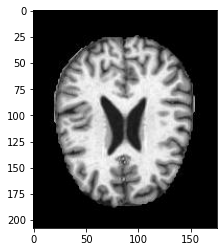

In [4]:
p=random.randint(0,data_train.shape[0])
p
photo=data_train.iloc[p,0]
image=cv2.imread(photo)/255
plt.imshow(image)
image.shape

## Classification

### Modele de CNN

In [5]:
model=tf.keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(208,176,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 103, 87, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 20, 128)      0

In [6]:
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=["acc"])

### Traitement des données

In [11]:
#from keras.preprocessing.image import ImageDataGenerator

#train_datagen=ImageDataGenerator(rescale=1./255)
#test_datagen=ImageDataGenerator(rescale=1./255)
data_test
def traitement(data):
    for i in range(0,data.shape[0]-1):
        images+=[cv2.imread(data.iloc[i:0])/255]
        labels+=[data.iloc[i:1]]

C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented0.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented1.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented2.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented3.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented4.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented5.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented6.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented7.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented8.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented9.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented10.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/MildDemented11.jpg
C:

C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2518.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2519.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2520.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2521.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2522.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2523.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2524.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2525.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2526.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2527.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2528.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/NonDemented2

In [17]:



path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
label=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    label.append(dirname.split('/')[-1])
    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        a=re.sub("\\\\","/",os.path.join(pat,filenames[j]))
        b=re.sub("\\\\","/",os.path.join(pat.split("/")[-1],str(j)+'.jpg'))
        j+=1
        #print(a)
        #print(b)

C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (19).jpg
MildDemented/0.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/ModerateDemented/27 (2).jpg
ModerateDemented/0.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/26 (100).jpg
NonDemented/0.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/VeryMildDemented/26 (44).jpg
VeryMildDemented/0.jpg


In [28]:
path="C:/Users/ranus/alzheimer/archive(1)/OriginalDataset"
folder_path=[]
for dirname,_, filename in os.walk(path):
    folder_path.append(dirname)
    
del folder_path[0] #On retire le 1er élément qui correspond au chemin path

for i in range(len(folder_path)):
    folder_path[i]=re.sub("\\\\","/",folder_path[i]) #On corrige les antislash en slash

    
#On renomme les fichiers
for pat in folder_path:
    j=0 #initalisationde l'accumulateur
    for dirname ,_, filenames  in os.walk(pat):
        for file in filenames:
            a=os.path.join(pat,file)
            print(re.sub("\\\\","/",a))

C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (19).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (20).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (21).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (22).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (23).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (24).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (25).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (26).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (27).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26 (28).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/26.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/27 (10).jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/MildDemented/27 (11).jpg
C:/U

C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem319.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem32.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem320.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem321.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem322.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem323.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem324.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem325.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem326.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem327.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem328.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/nonDem329.jpg
C:/Users/ranus/alzheimer/archive(1)/OriginalDataset/NonDemented/n